## Assignment 5 (50 marks)
#### =====================================================================================================
### Deadline: 11/16 11:59 pm
#### =====================================================================================================

### Problem 1: Regression (10 marks)

The dataset `lab05_dataset_1.csv` has the results of fraud investigations of 5,960 cases. For this task, you will use the input features *FRAUD, TOTAL_SPEND, NUM_CLAIMS, MEMBER_DURATION, OPTOM_PRESC, NUM_MEMBERS* to predict the output *DOCTOR_VISITS*.

### 1.a (2 marks)

1. Normalize the entire dataset.
2. Use a train-test split of 80-20.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def train_test_scaled(file: str = 'lab05_dataset_1.csv'):
    df = pd.read_csv(file)
    df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
    Xn = df_scaled.drop(columns=['DOCTOR_VISITS'])
    y = df_scaled['DOCTOR_VISITS'] 
    
    return train_test_split(Xn, y, test_size=0.20, random_state=42) 

if __name__ == '__main__':
    train_test_scaled()

### 1.b (4 marks)

Use sklearn's `LinearRegression` and `SGDRegressor` models for training and output their mean squared error on the test set. Your MSE should be less 0.95.

In [3]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error

FEATURES = ['FRAUD', 'TOTAL_SPEND', 'NUM_CLAIMS', 'MEMBER_DURATION', 'OPTOM_PRESC', 'NUM_MEMBERS']

def lin_reg():
    X_train, X_test, y_train, y_test = train_test_scaled()
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    return mean_squared_error(y_test, y_pred)

def sgd_reg():
    X_train, X_test, y_train, y_test = train_test_scaled()

    reg = SGDRegressor(max_iter=2000, tol=1e-3)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    return mean_squared_error(y_test, y_pred) 

if __name__ == '__main__':
    mse_lr = lin_reg()
    mse_sgd = sgd_reg()

    print(f"Linear Regression (MSE): {mse_lr:.4f}")
    print(f"SGD Regression (MSE): {mse_sgd:.4f}")


Linear Regression (MSE): 0.9117
SGD Regression (MSE): 0.9179


### 1.c (4 marks)

Use sklearn's `KNeighborsRegressor` model for training and output their mean squared error on the test set. Your MSE should be less 0.91. Feel free to tweak the parameters of neighbors, algorithm, and metric in the `KNeighborsRegressor` function to reach the desired MSE.

In [4]:
from sklearn.neighbors import KNeighborsRegressor

def k_neighbors():
    X_train, X_test, y_train, y_test = train_test_scaled()

    neigh = KNeighborsRegressor(n_neighbors=6, weights='distance', metric='manhattan')
    neigh.fit(X_train, y_train)

    y_pred = neigh.predict(X_test)

    return mean_squared_error(y_test, y_pred)

if __name__ == '__main__':
    mse = k_neighbors()

    print(f"K Neighbors Regressor (MSE): {mse:.4}")

K Neighbors Regressor (MSE): 0.836


### Problem 2: MLP Classification (20 marks)

`lab05_dataset_2.csv` contains 103,904 observations on airlines customer reviews. For this classification task, use the sklearn's `MLPClassifier` method, where the output class is the `Satisfaction` column which has a binary value of `Satisfied` or `Unsatisfied` and the remaining columns are the input features.

### 2.a (5 marks)

1. Drop any rows with missing values.
2. Output the new length of the final training dataset.
3. Apply encoding to convert all categorical features into numerical values.
4. Normalize the input features.
5. Apply a train-test split of 70-30.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler

def drop_missing():
    df = pd.read_csv('lab05_dataset_2.csv')
    print(f"Original: {df.shape}")
    df = df.dropna()
    print(f"After: {df.shape}")

    return df

def train_split():
    df = drop_missing()
    y = df['Satisfaction'].map({'Satisfied': 1, 'Unsatisfied': 0})
    X = df.drop(columns=['Satisfaction'])
        
    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', StandardScaler(), numeric_cols),
        ]
    )

    Xn = preprocess.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.30, random_state=42, stratify=y)

    print("Final training rows:", X_train.shape[0])

    return X_train, X_test, y_train, y_test

if __name__ == '__main__':
    train_split()

Original: (103904, 23)
After: (103594, 23)
Final training rows: 72515


### 2.b (10 marks)

Build two `MLPClassifier` neural networks such that `MSE < 0.05` between the test cases and the neural network predictions for both the networks. You are free to use any number of hidden layers, neurons per layer and activation function to reach your goal. However, both the networks must have the same number of hidden layers and neurons per layer, the only thing that should be different in the networks are their activation functions. Output the MSE for both the networks.

In [6]:
def MLP():
    X_train, X_test, y_train, y_test = train_split()

    common = dict(
        hidden_layer_sizes=(128, 64),
        solver='adam',
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=0.001,
        max_iter=300,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42,
    )

    mlp_relu = MLPClassifier(activation='relu', **common)
    mlp_relu.fit(X_train, y_train)
    proba_relu = mlp_relu.predict_proba(X_test)[:, 1]
    mse_relu = mean_squared_error(y_test, proba_relu)

    mlp_tanh = MLPClassifier(activation='tanh', **common)
    mlp_tanh.fit(X_train, y_train)
    proba_tanh = mlp_tanh.predict_proba(X_test)[:, 1]
    mse_tanh = mean_squared_error(y_test, proba_tanh)

    return mlp_relu, mlp_tanh, mse_relu, mse_tanh

if __name__ == '__main__':
    _, _, relu, tanh = MLP()

    print(f"MLP (ReLU) MSE: {relu:.4f}")
    print(f"MLP (tanh) MSE: {tanh:.4f}")

Original: (103904, 23)
After: (103594, 23)
Final training rows: 72515
MLP (ReLU) MSE: 0.0308
MLP (tanh) MSE: 0.0313


### 2.c (5 marks)

Plot the training loss trajectory together for both the neural network models generated above using two different activation functions. Make sure to add legends and labels to your plot.

Original: (103904, 23)
After: (103594, 23)
Final training rows: 72515


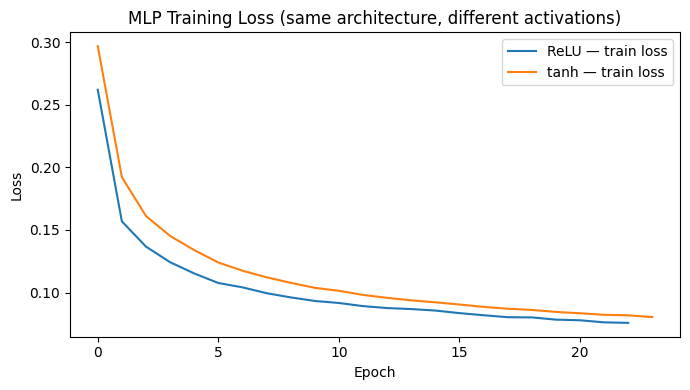

In [7]:
import matplotlib.pyplot as plt 

def plot_loss():
    mlp_relu, mlp_tanh, _, _ = MLP()

    plt.figure(figsize=(7,4))
    plt.plot(mlp_relu.loss_curve_, label='ReLU — train loss')
    plt.plot(mlp_tanh.loss_curve_, label='tanh — train loss')
    plt.title("MLP Training Loss (same architecture, different activations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    plot_loss()

### Problem 3: MLP Regression (20 marks)

`lab05_dataset_3.csv` contains 973 observations on gym data. For this prediction task, use the sklearn's `MLPRegressor` method, where the real-valued output feature is the `BMI` column and the remaining columns are the input features.

### 3.a (5 marks)

1. Drop any rows with missing values.
2. Output the new length of the final training dataset.
3. Apply encoding to convert all categorical features into numerical values.
4. Normalize the input features.
5. Apply a train-test split of 80-20.

In [18]:
def dropna():
    df = pd.read_csv('lab05_dataset_3.csv')
    df = df.dropna()
    return df

def train_test():
    df = dropna()
    y = df['BMI']
    X = df.drop(columns=['BMI'])

    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    numeric_cols = [c for c in X.columns if c not in categorical_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('num', MaxAbsScaler(), numeric_cols),
        ]
    )

    Xn = preprocess.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.20, random_state=42)

    print("Final training rows:", X_train.shape[0])

    return X_train, X_test, y_train, y_test

if __name__ == '__main__':
    train_test()

Final training rows: 778


### 3.b (10 marks)

Build two `MLPRegressor` neural networks such that `MSE < 0.02` between the test cases and the neural network predictions for both the networks. You are free to use any number of hidden layers, neurons per layer and activation function to reach your goal. However, both the networks must have the same number of hidden layers and neurons per layer, the only thing that should be different in the networks are their activation functions. Output the MSE for both the networks.

In [33]:
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

def MLP_gym():
    X_train, X_test, y_train, y_test = train_test()

    # Standardize target for training *and* for the MSE threshold check
    y_scaler = StandardScaler()
    z_train = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
    z_test  = y_scaler.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

    common = dict(
        hidden_layer_sizes=(128, 64),
        solver='adam',             # use adam so we can also plot loss later
        alpha=3e-4,
        batch_size=128,
        learning_rate_init=1e-3,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42,
        verbose=False
    )

    mlp_relu = MLPRegressor(activation='relu', **common)
    mlp_relu.fit(X_train, z_train)
    z_pred_relu = mlp_relu.predict(X_test)
    mse_relu_std = mean_squared_error(z_test, z_pred_relu)      

    mlp_tanh = MLPRegressor(activation='tanh', **common)
    mlp_tanh.fit(X_train, z_train)
    z_pred_tanh = mlp_tanh.predict(X_test)
    mse_tanh_std = mean_squared_error(z_test, z_pred_tanh)         

    return mlp_relu, mlp_tanh, mse_relu_std, mse_tanh_std

if __name__ == '__main__':
    _, _, relu, tanh = MLP_gym()

    print(f"MLP (ReLU) MSE: {relu:.4f}")
    print(f"MLP (tanh) MSE: {tanh:.4f}")

Final training rows: 778
MLP (ReLU) MSE: 0.0075
MLP (tanh) MSE: 0.0143


### 3.c (5 marks)

Plot the training loss trajectory together for both the neural network models generated above using two different activation functions. Make sure to add legends and labels to your plot.

Final training rows: 778


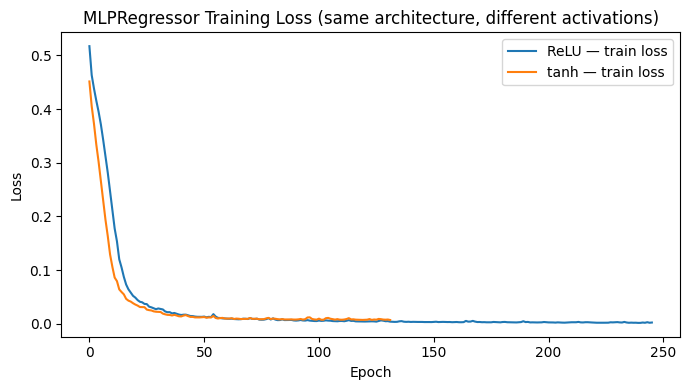

In [34]:
def plot_mlp_loss():
    mlp_relu, mlp_tanh, _, _ = MLP_gym() 

    plt.figure(figsize=(7,4))
    plt.plot(mlp_relu.loss_curve_, label='ReLU — train loss')
    plt.plot(mlp_tanh.loss_curve_, label='tanh — train loss')
    plt.title("MLPRegressor Training Loss (same architecture, different activations)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    plot_mlp_loss()